# 05 - Non-negative Matrix Factorization
This notebook implements a second model-based algorithm - non-negative matrix factorization - for comparison purposes. We use the NMF module from Surprise and choose MAE as the performance metric. We again use fmin from Hyperopt to optimize the hyperparameters. Similar to the previous models, we perform a runtime analysis in the second part of this notebook.

In [2]:
from surprise import Dataset, evaluate, NMF, Reader

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

sns.set(style='whitegrid')
% matplotlib inline

In [3]:
# set file paths and read in samples
data_path = os.path.join('..','..','data')
data_file_100 = os.path.join(data_path, 'reviews_sample_100.csv')
data_file_50 = os.path.join(data_path, 'reviews_sample_50.csv')
data_file_25 = os.path.join(data_path, 'reviews_sample_25.csv')
data_file_10 = os.path.join(data_path, 'reviews_sample_10.csv')

df_100 = pd.read_csv(data_file_100).drop('Unnamed: 0', axis = 1)
df_50 = pd.read_csv(data_file_50).drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv(data_file_25).drop('Unnamed: 0', axis = 1)
df_10 = pd.read_csv(data_file_10).drop('Unnamed: 0', axis = 1)

In [4]:
# use the load_from_df function from Suprise's Dataset module.
# this function requires the rating scale to be specified.
reader = Reader(rating_scale=(1,5))
sdf_100 = Dataset.load_from_df(df_100[['reviewerID', 'asin', 'overall']], reader=reader)

Surprise's NMF model can be tuned with six hyperparameters:
1. n_epochs: the number of epochs a model trains for prior to termination
2. n_factors: number of latent factors
3. reg_pu: regularization term for latent user parameters
4. reg_qi: regularization term for latent item parameters
5. reg_bu: regularization term for user bias
6. reg_bi: regularization term for item bias

To search for optimal hyperparameter values, we eschew grid search for a more efficient and effective Bayesian optimization method using **tree parzen estimators** provided by the Hyperopt library.

In [5]:
def test_nmf(params):
    '''Test NMF with specified hyperparameter settings and define cross-validated MAE as loss.
       This function will later be fed into fmin to find optimized hyperparameters.
    '''
    model = NMF(**params)
    sdf_100.split(3, shuffle=True)
    results = evaluate(model, sdf_100, measures = ['mae'], verbose=True)
    mae = np.array(results['mae']).mean()
    return mae

In [6]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_nmf'), 'rb') as file_in:
        trials = pkl.load(file_in)
    with open(os.path.join(data_path, 'best_nmf.dict'), 'rb') as file_in:
        best = pkl.load(file_in)
else:
    
    # set the range of hyperparameters for the NMF model
    trials = Trials()
    space = {
        'n_factors': hp.choice('n_factors', list(range(10, 61))),
        'n_epochs': hp.choice('n_epochs', list(range(10,31))),
        'reg_pu': hp.uniform('reg_pu', 0, 0.1),
        'reg_qi': hp.uniform('reg_qi', 0, 0.1),
        'reg_bu': hp.uniform('reg_bu', 0, 0.1),
        'reg_bi': hp.uniform('reg_bi', 0, 0.1)
    }
    
    '''Use Tree-structured Parzen Estimator (TPE) as the algorithm used
       to optimize the objective function'''
    best = fmin(algo = tpe.suggest,
               fn = test_nmf,
               trials = trials,
               max_evals = 100,
               space = space)
    with open(os.path.join(data_path, 'trials_nmf'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_nmf.dict'), 'wb') as file_out:
        pkl.dump(best, file_out)

This section below, accompanied by various graphs, visulizes the distribution of the different values each hyperparameter can take and the corresponding loss values.

In [7]:
def val_diagnostic(val_name, trials):
    
    '''For hyperparameters that are specified with hp.choice, such as a range of integers,
       Hyperopt returns the index of the tested hyperparameter value rather than the value itself.
       Thus, for hyperparameter ranges that begin at a non-zero point,
       it is necessary to shift the indices to the corresponding values they represent.
    '''
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    if val_name == 'n_epochs':
        vals += 10
    elif val_name == 'n_factors':
        vals += 10
        
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss')
    plt.tight_layout()

For each hyperparameter, namely the number of latent factors, number of epochs, and the regularization term, we make three plots to understand its distribution and performance. The first and second graphs are respectively a scatterplot and a histogram, in order to visualize where the values tend to cluster as the algorithm optimizes. The third graph is a loss vs. values plot that visualizes how MAE changes with hyperparameter different values. The algorithm picks the combination of hyperparameter values where loss is minimized.

Unsurprisingly, NMF performs better when it allowed to train for greater numbers of epochs. However, it appears that lower numbers of latent factors improve the model's performance, likely because too many latent factors contribute to overfitting.

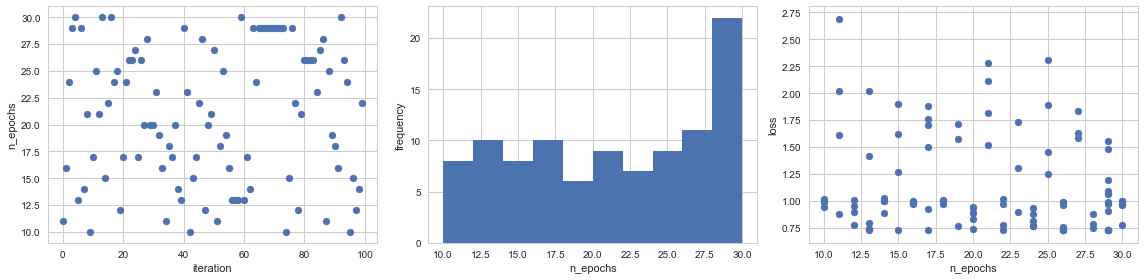

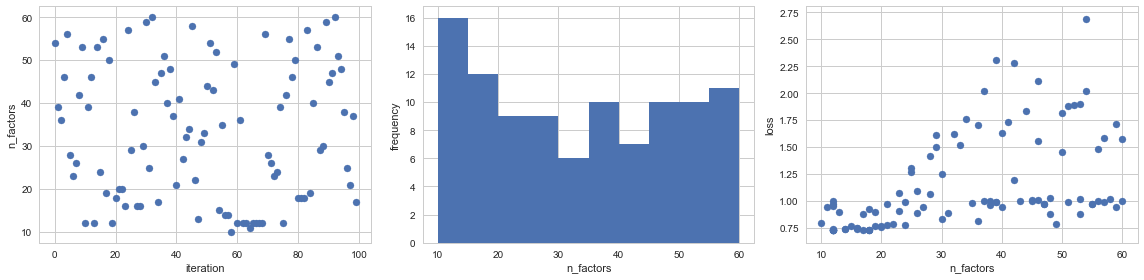

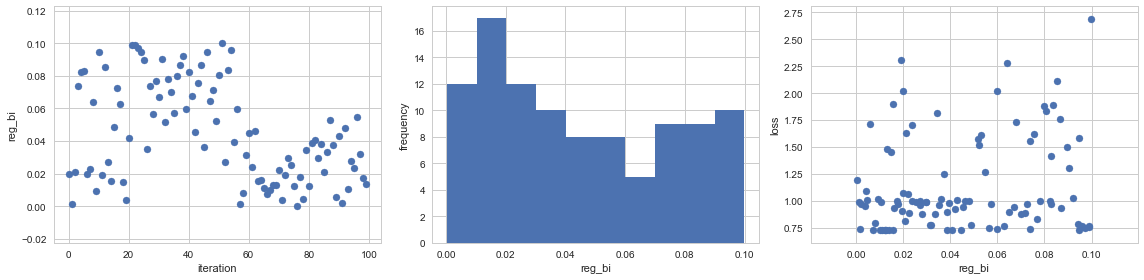

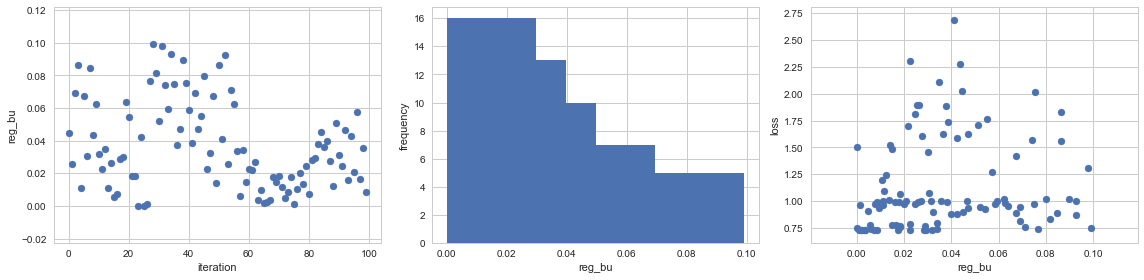

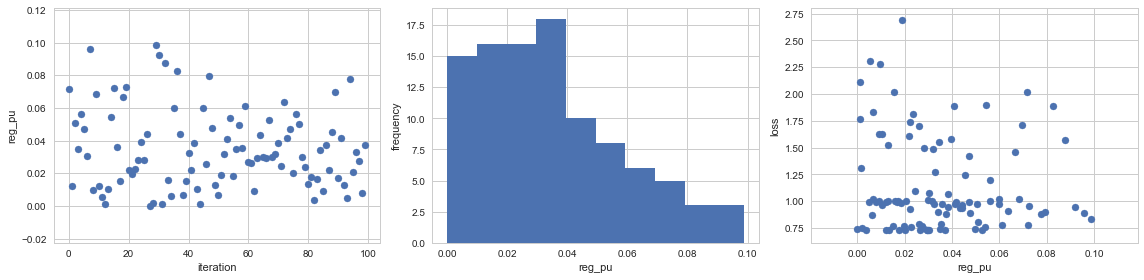

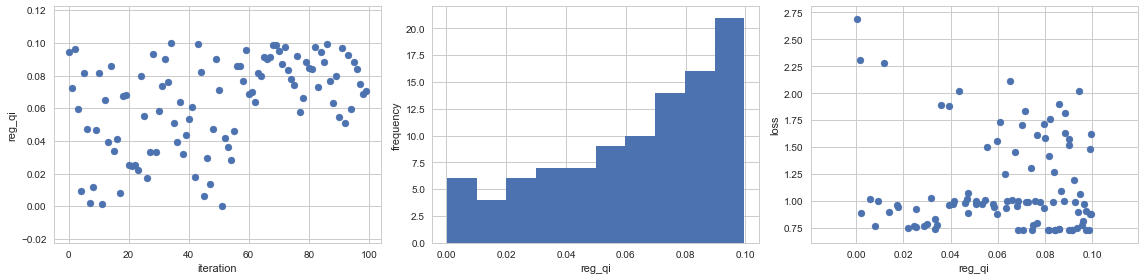

In [8]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [10]:
# optimized hyperparameter values
if not use_pretrained:
    best_adjusted = best.copy()
    best_adjusted['n_epochs'] += 10
    best_adjusted['n_factors'] += 10
    with open(os.path.join(data_path, 'best_nmf.dict'), 'wb') as file_out:
            pkl.dump(best_adjusted, file_out)
else:
    best_adjusted = best.copy()
    
print(best_adjusted)

{'n_epochs': 26, 'n_factors': 18, 'reg_bi': 0.03854271656017266, 'reg_bu': 0.028470122296085858, 'reg_pu': 0.01751982388134818, 'reg_qi': 0.08412948486752997}


In [18]:
# feed in the optimized hyperparameters to NMF and evaluate 5-fold cross-validated MAE
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'results_nmf.array'), 'rb') as file_in:
        results = pkl.load(file_in)
else:
    model = NMF(**best_adjusted)
    
    # split the dataset into 5 folds for cross-validation
    sdf_100.split(5)
    results = evaluate(model, sdf_100, measures = ['mae'])
    with open(os.path.join(data_path, 'results_nmf.array'), 'wb') as file_out:
        pkl.dump(results, file_out)

Evaluating MAE of algorithm NMF.

------------
Fold 1
MAE:  0.7177
------------
Fold 2
MAE:  0.7194
------------
Fold 3
MAE:  0.7238
------------
Fold 4
MAE:  0.7211
------------
Fold 5
MAE:  0.7251
------------
------------
Mean MAE : 0.7214
------------
------------


Using the optimized hyperparameters, we find the median MAE of the NMF model to be around 0.721, which is better than SVD. However, the variance is larger.

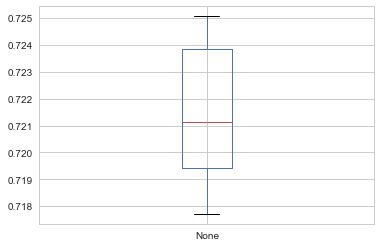

In [19]:
pd.Series(results['mae']).plot(kind = 'box')

# Runtime analysis
In this part of the notebook, we run the NMF model with different sample sizes in order to explore how runtime scales as sample size increases. For each sample size, we run the model for 1 iteration, and record the difference between start time and end time.

In [52]:
df_list = [df_10, df_25, df_50, df_100]

use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'runtime_nmf.list'), 'rb')as file_in:
        runtime_list = pkl.load(file_in)
else:
    runtime_list = list()
    for df in df_list:
        sdf = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader=reader)
        train = sdf.build_full_trainset()

        start = time.time()
        model.train(train)
        end = time.time()

        runtime_list.append(end-start)

    with open(os.path.join(data_path, 'runtime_nmf.list'), 'wb')as file_out:
        pkl.dump(runtime_list, file_out)

Here we observe that, for the NMF model with optimized parameters, runtime tends to scale linearly as sample size increases, but with a flatter rate in comparison to SVD.

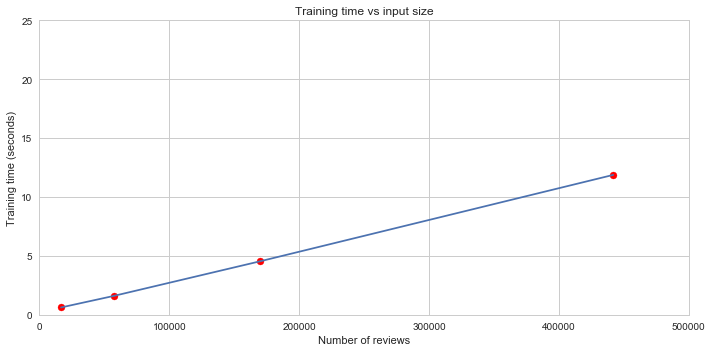

In [53]:
n_reviews_list = [len(df) for df in df_list]
plt.figure(figsize = (10, 5))
plt.plot(n_reviews_list, runtime_list)
plt.scatter(n_reviews_list, runtime_list, color = 'red')
plt.ylim(0, 25)
plt.xlim(0, 500000)
plt.xlabel('Number of reviews')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs input size')
plt.tight_layout()